In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train_path='/kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder'
test_path='/kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder'

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
train_ds = ImageFolder(root=train_path, transform=train_transforms)
test_ds = ImageFolder(root=test_path, transform= test_transforms)

In [11]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1000)

In [12]:
class CNN(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        
        #ConvLayer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )  
        #ConvLayer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #ConvLayer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #ConvLayer 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        #Global Adaptive Pool
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        #Dropout
        self.dropout = nn.Dropout(0.1)
        #fully connected layer
        self.fc = nn.Linear(128, 256)
        self.output = nn.Linear(256, 30)
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.global_pool(x)
        
        #Flatten
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc(x))

        return self.output(x)

In [13]:
#Accessing gpu
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [14]:
dev = set_device()
model = CNN().to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay=0.0001)

In [15]:
train_losses=[]
train_accuracies=[]
test_losses=[]
test_accuracies=[]
filtered_preds=[]
filtered_labels=[]
all_preds=[]
all_labels=[]

In [30]:
#training the model
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  device = set_device()
  best_acc = 0

  for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    best_acc = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      train_total += labels.size(0)

      optimizer.zero_grad()
      outputs = model(images)
      predicted = torch.argmax(outputs, 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_correct += (labels==predicted).sum().item()

    train_losses.append(train_loss/len(train_loader))
    train_accuracies.append(100*train_correct/train_total)
    
    print(f"Epoch: {epoch +1} \n Training Accuracy: {100*train_correct/train_total:.2f}%, Loss: {train_loss/len(train_loader):.4f}")

    # get_predictions_and_labels(model, test_loader, device)
      
    test_acc = evaluate(model, test_loader)

    if(test_acc > best_acc):
      best_acc = test_acc
      save_checkpoint(model, epoch, optimizer, best_acc)
        
  plt.figure(figsize=(10, 4))
  plt.plot(train_losses, label="Training losses", color="red", marker="o")
  plt.plot(test_losses, label="Testing losses", color="green", marker="o")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracies')
  plt.title('Training losses vs Testing losses')
  plt.legend()
  plt.grid(True)
  plt.show(block=False)
    
  plt.figure(figsize=(10, 4))
  plt.plot(train_accuracies, label="Traning Accuracies", color="red", marker="o")
  plt.plot(test_accuracies, label="Testing Accuracies", color="blue", marker="o")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracies")
  plt.title("Training accuracies vs Testing accuracies")
  plt.legend()
  plt.grid(True)
  plt.show(block=False)  

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    test_correct=0
    test_total=0
    device = set_device()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            predicted = torch.argmax(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            test_loss += loss.item()
            all_preds.extend(predicted.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    test_losses.append(test_loss/len(test_loader))
    test_accuracies.append(100*test_correct/test_total)
    epoch_acc = 100*test_correct/test_total
    
    print(f"Test Accuracy: {epoch_acc:.2f}%, Loss: {test_loss/len(test_loader):.4f}")
    return epoch_acc

In [32]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state={
        'epoch':epoch+1,
        'model':model.state_dict(),
        'best_accuracy':best_acc,
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [40]:
#using Resnet18 pretrained model
import torchvision.models as models

resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in resnet18_model.parameters():
    param.requires_grad = False
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, 30)
resnet18_model = resnet18_model.to(dev)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model.parameters()), lr = 0.001)

Epoch: 1 
 Training Accuracy: 81.62%, Loss: 0.5959
Test Accuracy: 79.70%, Loss: 0.6425
Epoch: 2 
 Training Accuracy: 90.57%, Loss: 0.2846
Test Accuracy: 70.02%, Loss: 1.3557
Epoch: 3 
 Training Accuracy: 93.55%, Loss: 0.1884
Test Accuracy: 79.71%, Loss: 0.8101
Epoch: 4 
 Training Accuracy: 94.64%, Loss: 0.1558
Test Accuracy: 81.23%, Loss: 0.7144
Epoch: 5 
 Training Accuracy: 95.72%, Loss: 0.1262
Test Accuracy: 85.03%, Loss: 0.5729
Epoch: 6 
 Training Accuracy: 96.20%, Loss: 0.1141
Test Accuracy: 84.93%, Loss: 0.5668
Epoch: 7 
 Training Accuracy: 96.40%, Loss: 0.1052
Test Accuracy: 88.00%, Loss: 0.3978
Epoch: 8 
 Training Accuracy: 96.90%, Loss: 0.0959
Test Accuracy: 86.76%, Loss: 0.4847
Epoch: 9 
 Training Accuracy: 97.18%, Loss: 0.0831
Test Accuracy: 86.35%, Loss: 0.5944
Epoch: 10 
 Training Accuracy: 97.34%, Loss: 0.0785
Test Accuracy: 86.66%, Loss: 0.5058


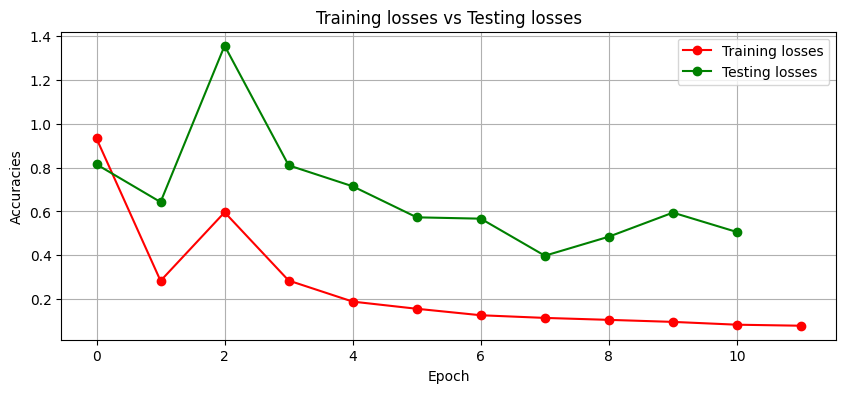

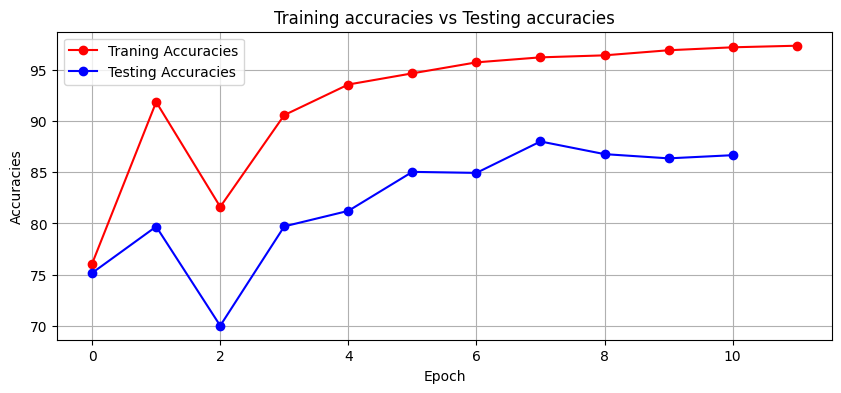

In [41]:
train_nn(resnet18_model, train_loader, test_loader, criterion, optimizer, 10)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.6380    0.9397    0.7600      9588
           1     0.8914    0.9363    0.9133      9588
           2     0.9377    0.7297    0.8207      9588
           3     0.6726    0.7368    0.7032      9588
           4     0.8521    0.9676    0.9062      9588
           5     0.8295    0.8301    0.8298      9588
           6     0.9789    0.8724    0.9226      9588
           7     0.9261    0.9097    0.9178      9600
           8     0.9950    0.5216    0.6844      9588
           9     0.9650    0.7451    0.8409      9588
          10     0.8522    0.9047    0.8777      9588
          11     0.8204    0.8538    0.8368      9588
          12     0.8165    0.8807    0.8474      9588
          13     0.9494    0.5926    0.7297      9588
          14     0.7984    0.9021    0.8471      9588
          15     0.9195    0.6863    0.7860      9588
          16     0.5296    0.8374    0.6489      9588
          17     0.9286    

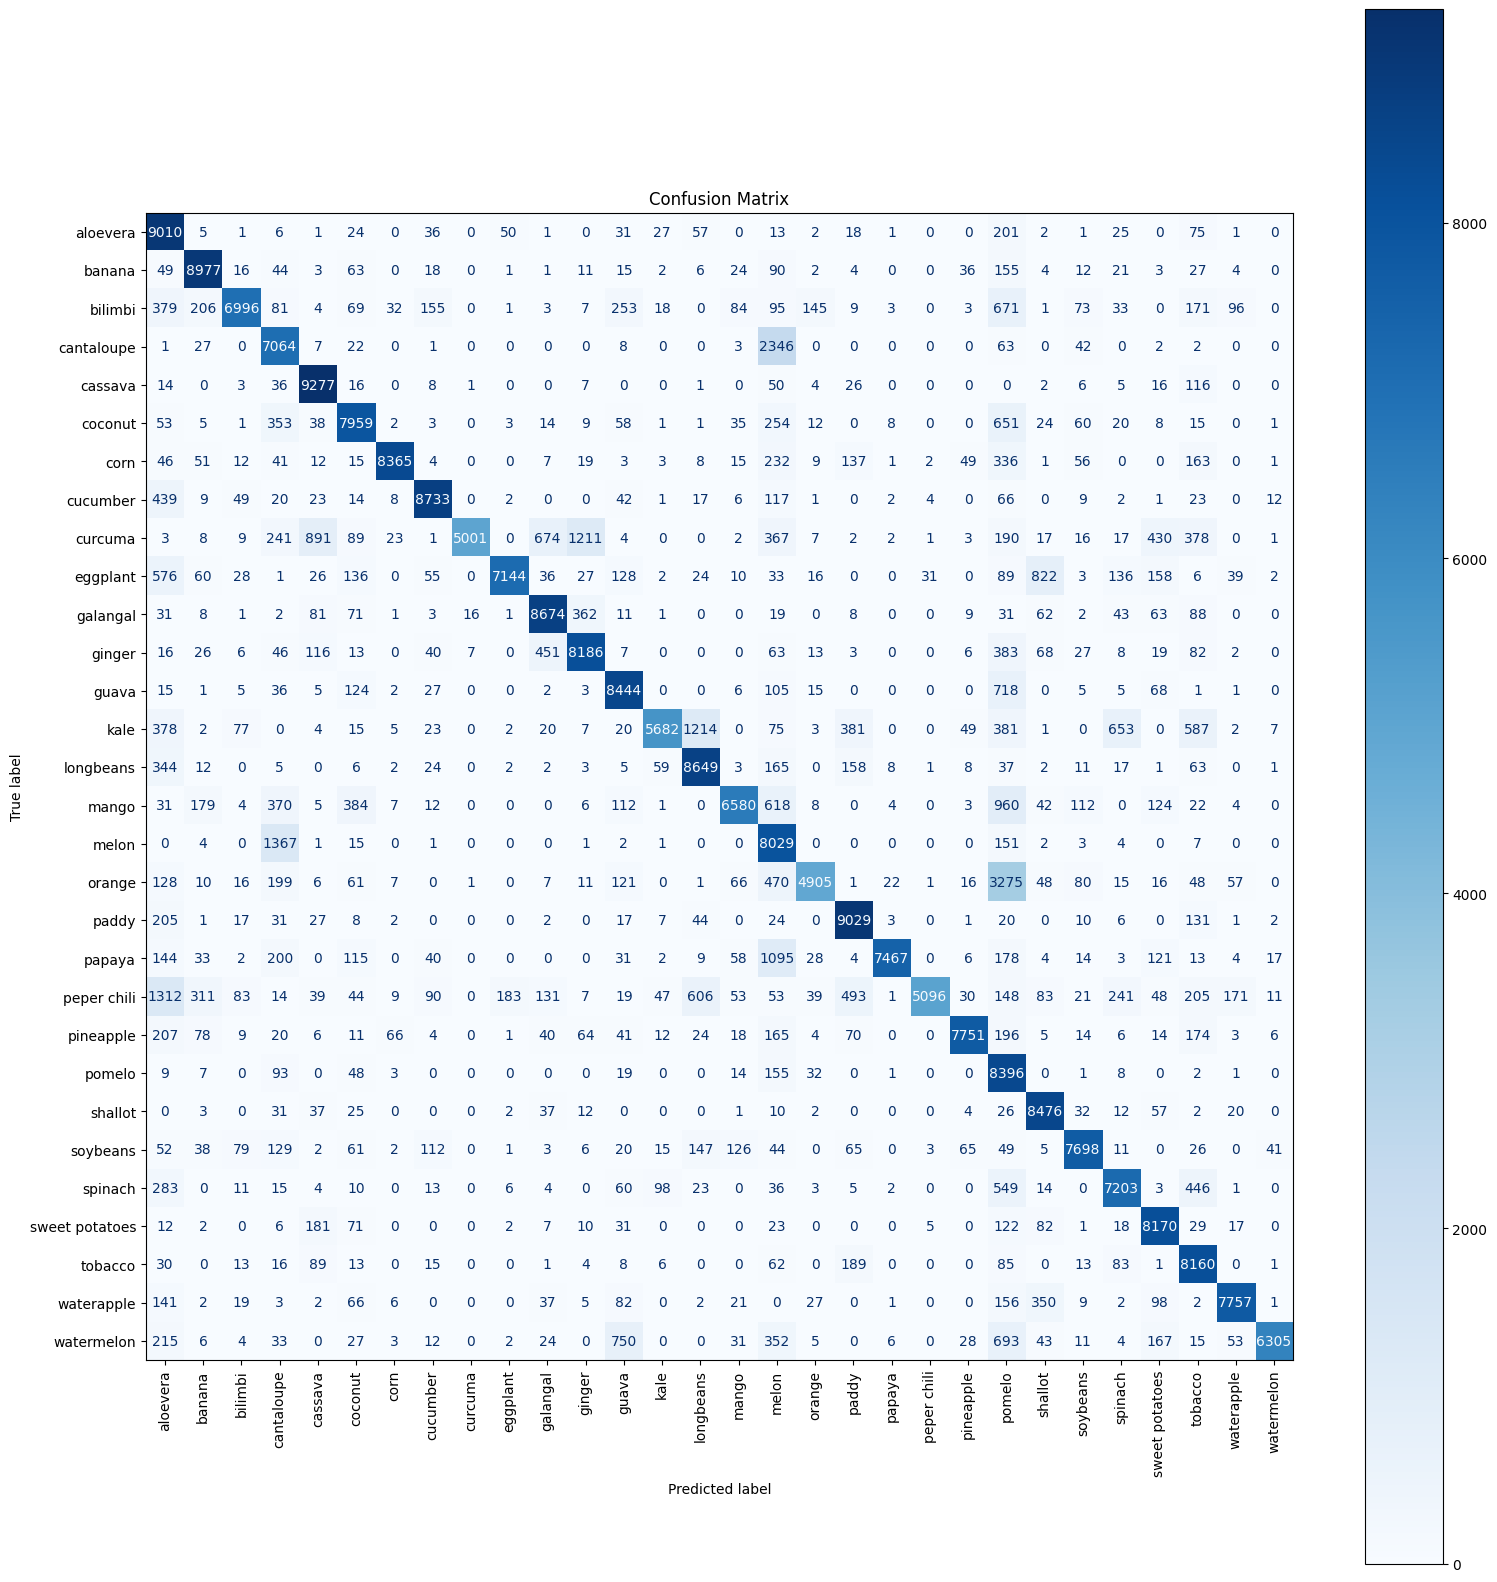

In [58]:
cm = confusion_matrix(all_labels, all_preds)
labels = test_ds.classes
fig, ax = plt.subplots(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.tight_layout()
plt.title("Confusion Matrix")
plt.show()